In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
import numpy as np
from cycler import cycler
from sklearn.cross_validation import (train_test_split, 
                                      StratifiedKFold, 
                                      permutation_test_score)
import seaborn as sns
from patsy import dmatrices, dmatrix



/home/johnchase/.conda/envs/data-analysis/lib/python3.4/site-packages/matplotlib/__init__.py:876: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Load data
-------

In [2]:
alpha = pd.read_csv('../alpha_build.txt', index_col=0, sep='\t')

Create the design matrix
------------------

In [3]:
all_cats = 'PD ~ {0}'.format(' + '.join(alpha.drop(['PD', 'NormDate', 
                                                      'Sequences Per Sample', 
                                                      'Phylogenetic Diversity', 'Office'], axis=1).columns))

comp_inters = """ + RH:PlateLocation + RH:temp:PlateLocation + np.log(temp) + np.log(RH) + np.power(RH, 2) + np.power(RH, 3) + RH:temp + RH:temp:wa"""
col_matrix = all_cats + comp_inters
col_matrix

'PD ~ City + PlateLocation + RH + illum + occupancy + surftemp + temp + wa + Period + RH:PlateLocation + RH:temp:PlateLocation + np.log(temp) + np.log(RH) + np.power(RH, 2) + np.power(RH, 3) + RH:temp + RH:temp:wa'

In [4]:
y, X = dmatrices(col_matrix,  data=alpha, return_type="dataframe")
y = y.PD
X.drop('Intercept', axis=1, inplace=True)

Create test and training sets
---------------------------

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

Plot lambda vs. coefficients
--------------------------

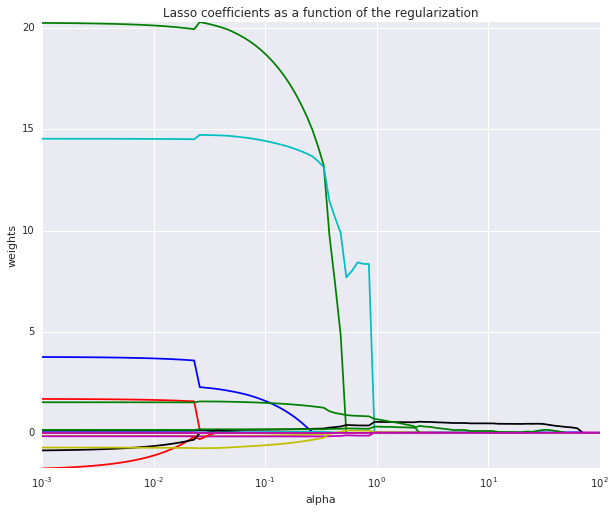

In [6]:
n_alphas=100
alphas = np.logspace(-3, 2, n_alphas)
clf = linear_model.Lasso(fit_intercept=False, tol=0.1)

coefs = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X_train, y_train)
    coefs.append(clf.coef_)

###############################################################################
# Display results
plt.figure(figsize=[10, 8])
ax = plt.gca()
ax.set_prop_cycle(cycler('color', ['b', 'r', 'g', 'c', 'k', 'y', 'm']))

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

Fit model using 10-fold CV
---------------------
Here the alphas are chosen based where the coefficients go to 0

In [7]:
n_alphas=1000
alphas = np.logspace(-3, 2, n_alphas)
model = linear_model.LassoCV(alphas=alphas, max_iter=10000, cv=10, tol=.1).fit(X, y)

/home/johnchase/.conda/envs/data-analysis/lib/python3.4/site-packages/sklearn/linear_model/base.py:424: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':
/home/johnchase/.conda/envs/data-analysis/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/home/johnchase/.conda/envs/data-analysis/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


Plot the MSE for -log(alpha)
-------------------------

(-2.0, 3.0, 17.34320911981597, 118.31214020599532)

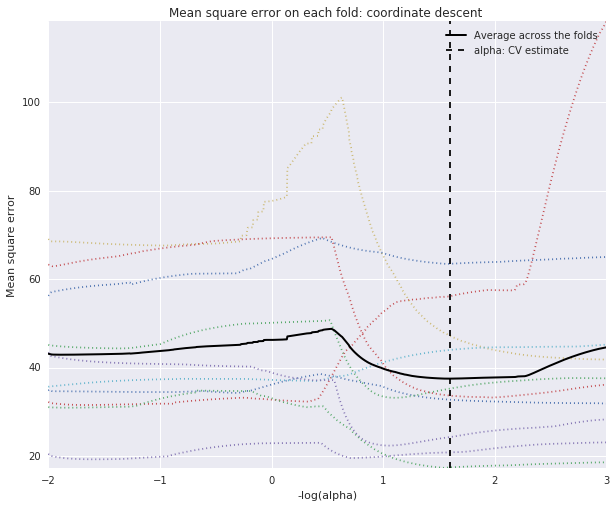

In [8]:
m_log_alphas = -np.log10(model.alphas_)

plt.figure(figsize=(10, 8))
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')
plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent ')
plt.axis('tight')

Run model on test set
------------------

In [9]:
print('MSE: {0}'.format(np.mean((model.predict(X_test) - y_test)**2)))
pd.Series(np.insert(model.coef_, 0, model.intercept_), index=["Intercept"] + X.columns.tolist())

MSE: 25.523401769598493


Intercept                         16.331775
City[T.sandiego]                  -1.392071
City[T.toronto]                   -2.622984
PlateLocation[T.floor]            20.177738
PlateLocation[T.wall]              0.000000
RH                                 0.280024
RH:PlateLocation[T.floor]          0.306262
RH:PlateLocation[T.wall]           0.000000
illum                             -0.005630
occupancy                         -0.000000
surftemp                           0.000000
temp                               0.081185
wa                                 0.000000
Period                            -0.229763
RH:temp                           -0.012333
RH:temp:PlateLocation[T.floor]    -0.023854
RH:temp:PlateLocation[T.wall]      0.001904
np.log(temp)                      -0.000000
np.log(RH)                         0.000000
np.power(RH, 2)                   -0.004259
np.power(RH, 3)                   -0.000047
RH:temp:wa                         0.029531
dtype: float64

R<sup>2</sup> Value
-------

In [10]:
model.score(X_test, y_test)

0.55187259098581487